# TP Partie 1 : G√©n√©ration de Dataset Synth√©tique pour le Fine-tuning de LLM

## üìö Contexte

Dans ce notebook, nous allons explorer la g√©n√©ration de datasets d'instruction synth√©tiques, une technique cl√© pour cr√©er des donn√©es d'entra√Ænement pour le fine-tuning de mod√®les de langage. Cette approche permet de :

- **Cr√©er des donn√©es d'entra√Ænement** sans annotation manuelle co√ªteuse
- **Adapter un mod√®le** √† des domaines sp√©cifiques
- **Augmenter la diversit√©** des donn√©es existantes

## üéØ Objectifs

1. **Comprendre** le processus de g√©n√©ration de donn√©es synth√©tiques
2. **Impl√©menter** une pipeline de g√©n√©ration bas√©e sur des documents sources
3. **Cr√©er** un dataset au format instruction-response utilisable pour le fine-tuning
4. **Analyser** la qualit√© et la diversit√© des donn√©es g√©n√©r√©es

## üîß Architecture

Notre approche s'inspire de la m√©thodologie AWS pour la g√©n√©ration de donn√©es synth√©tiques :

1. **Extraction de contexte** : Nous utilisons le corpus Common Corpus (split fran√ßais)
2. **G√©n√©ration de questions** : Un LLM g√©n√®re des questions pertinentes bas√©es sur le contexte
3. **G√©n√©ration de r√©ponses** : Le m√™me ou un autre LLM g√©n√®re des r√©ponses aux questions
4. **Formatage** : Structuration au format instruction-suivie pour le fine-tuning

## ‚öôÔ∏è Configuration

Nous utilisons :
- **vLLM** : Serveur d'inf√©rence haute performance (d√©j√† configur√© sur votre machine)
- **Qwen3-4B** : Mod√®le de base pour la g√©n√©ration
- **Common Corpus** : Dataset source en fran√ßais

## 1. Import des biblioth√®ques et configuration

In [25]:
import json
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datasets import load_dataset
from openai import OpenAI
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration visuelle
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)

In [41]:
MODEL_NAME: str = "Qwen/Qwen3-4B-Instruct-2507"
VLLM_HOST_IP: str = "51.159.189.97"
VLLM_TOKEN: str = "ecn-llm-token-update-this-secret"  # Token d√©fini dans start_vllm.sh

## 2. Configuration du client vLLM

**Note importante** : Assurez-vous que votre serveur vLLM est lanc√© (`make vllm` dans un terminal s√©par√©)

In [42]:
# Configuration du client OpenAI pour vLLM
client = OpenAI(
    base_url=f"http://{VLLM_HOST_IP}:8000/v1",
    api_key=VLLM_TOKEN
)

# Test de connexion
try:
    models = client.models.list()
    print("‚úÖ Connexion au serveur vLLM r√©ussie")
    print(f"Mod√®le disponible : {models.data[0].id if models.data else 'Aucun'}")
except Exception as e:
    print(f"‚ùå Erreur de connexion : {e}")
    print("Assurez-vous d'avoir lanc√© le serveur vLLM avec 'make vllm'")

‚ùå Erreur de connexion : Connection error.
Assurez-vous d'avoir lanc√© le serveur vLLM avec 'make vllm'


## 3. Chargement du dataset source

Nous utilisons le **Common Corpus** en fran√ßais comme base pour g√©n√©rer nos instructions synth√©tiques.

In [4]:
# Chargement du dataset
print("Chargement du dataset Common Corpus (split fran√ßais)...")
dataset = load_dataset(
    "PleIAs/common_corpus",
    split="train",
    streaming=True,  # Streaming pour √©conomiser la m√©moire
)

# √âchantillonnage pour le TP (ajustez selon vos besoins)
SAMPLE_SIZE = 100  # Nombre de documents √† traiter
documents = []

print(f"Extraction de {SAMPLE_SIZE} documents...")
for i, doc in enumerate(tqdm(dataset, total=SAMPLE_SIZE)):
    if i >= SAMPLE_SIZE:
        break
    # Filtrer les documents trop courts ou trop longs
    if doc.get('text') and 100 < len(doc['text']) < 2000:
        documents.append(doc['text'])

print(f"\nüìä Documents collect√©s : {len(documents)}")
print(f"Longueur moyenne : {np.mean([len(d) for d in documents]):.0f} caract√®res")

Chargement du dataset Common Corpus (split fran√ßais)...


Resolving data files:   0%|          | 0/10011 [00:00<?, ?it/s]

Extraction de 100 documents...


  0%|          | 0/100 [00:00<?, ?it/s]


üìä Documents collect√©s : 36
Longueur moyenne : 691 caract√®res


## 4. D√©finition des structures de donn√©es

Nous utilisons des dataclasses pour structurer nos donn√©es de mani√®re claire et typ√©e.

In [26]:
@dataclass
class InstructionPair:
    """Structure pour une paire instruction-r√©ponse"""
    instruction: str
    response: str
    context: str
    metadata: Dict = None
    
    def to_dict(self) -> Dict:
        return asdict(self)
    
    def to_alpaca_format(self) -> Dict:
        """Conversion au format Alpaca standard"""
        return {
            "instruction": self.instruction,
            "input": "",  # Contexte optionnel
            "output": self.response
        }

## 5. Pipeline de g√©n√©ration synth√©tique

### 5.1 Prompts pour la g√©n√©ration

Nous d√©finissons des prompts soigneusement con√ßus pour g√©n√©rer des questions et r√©ponses de qualit√©.

In [7]:
# Templates de prompts pour la g√©n√©ration
QUESTION_GENERATION_PROMPT = """Tu es un assistant p√©dagogique expert. √Ä partir du texte suivant, g√©n√®re une question pertinente en fran√ßais.

La question doit :
- √ätre claire et pr√©cise
- √ätre directement bas√©e sur le contenu du texte
- √ätre formul√©e en fran√ßais correct
- √ätre adapt√©e pour un test de compr√©hension

Texte source :
{context}

G√©n√®re une seule question de haute qualit√©.
"""

ANSWER_GENERATION_PROMPT = """Tu es un assistant expert. R√©ponds √† la question suivante de mani√®re claire, pr√©cise et p√©dagogique en te basant sur le contexte fourni.

Contexte :
{context}

Question :
{question}

R√©ponse :
"""

### 5.2 Fonctions de g√©n√©ration

In [27]:
def generate_question(context: str) -> str:
    """
    G√©n√®re une question bas√©e sur un contexte donn√© en utilisant structured output.
    
    Args:
        context: Le texte source
    
    Returns:
        Question g√©n√©r√©e
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant qui g√©n√®re des questions p√©dagogiques."},
                {"role": "user", "content": QUESTION_GENERATION_PROMPT.format(
                    context=context[:1500]  # Limiter la longueur du contexte
                )}
            ],
            temperature=0.7,
            max_tokens=200,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "question_response",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "question": {
                                "type": "string",
                                "description": "La question g√©n√©r√©e bas√©e sur le contexte"
                            }
                        },
                        "required": ["question"],
                        "additionalProperties": False
                    }
                }
            }
        )
        
        # Extraction de la question du JSON structur√©
        content = response.choices[0].message.content
        import json
        result = json.loads(content)
        return result["question"]
        
    except Exception as e:
        print(f"Erreur lors de la g√©n√©ration de question : {e}")
        return "Quelle est l'id√©e principale de ce texte ?"


def generate_answer(context: str, question: str) -> str:
    """
    G√©n√®re une r√©ponse √† une question bas√©e sur un contexte.
    
    Args:
        context: Le texte source
        question: La question √† r√©pondre
    
    Returns:
        R√©ponse g√©n√©r√©e
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant expert qui r√©pond de mani√®re claire et p√©dagogique."},
                {"role": "user", "content": ANSWER_GENERATION_PROMPT.format(
                    context=context[:1500],
                    question=question
                )}
            ],
            temperature=0.3,  # Temp√©rature plus basse pour des r√©ponses coh√©rentes
            max_tokens=500
        )
        
        return response.choices[0].message.content.strip()
        
    except Exception as e:
        print(f"Erreur lors de la g√©n√©ration de r√©ponse : {e}")
        return "Je ne peux pas r√©pondre √† cette question bas√©e sur le contexte fourni."

### 5.3 Pipeline compl√®te de g√©n√©ration

In [28]:
def process_single_document(doc: str) -> Optional[InstructionPair]:
    """
    Traite un seul document pour g√©n√©rer une paire instruction-r√©ponse.
    
    Args:
        doc: Le document √† traiter
    
    Returns:
        InstructionPair ou None si la g√©n√©ration √©choue
    """
    try:
        # Cr√©er un client local pour ce thread
        thread_client = OpenAI(
            base_url=f"http://{VLLM_HOST_IP}:8000/v1",
            api_key=VLLM_TOKEN
        )
        
        # G√©n√©rer une seule question
        question = generate_question_with_client(thread_client, doc)
        
        if question and len(question) > 10:  # Filtre de qualit√© basique
            # G√©n√©rer la r√©ponse
            answer = generate_answer_with_client(thread_client, doc, question)
            
            if answer and len(answer) > 20:  # Filtre de qualit√© pour la r√©ponse
                return InstructionPair(
                    instruction=question,
                    response=answer,
                    context=doc[:500],  # Garder un extrait du contexte
                    metadata={
                        "source": "common_corpus_fr",
                        "generation_method": "vllm_qwen3_4b_structured_concurrent"
                    }
                )
    except Exception as e:
        print(f"Erreur lors du traitement d'un document : {e}")
    
    return None


def generate_question_with_client(client: OpenAI, context: str) -> str:
    """
    G√©n√®re une question bas√©e sur un contexte donn√© en utilisant structured output.
    
    Args:
        client: Le client OpenAI √† utiliser
        context: Le texte source
    
    Returns:
        Question g√©n√©r√©e
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant qui g√©n√®re des questions p√©dagogiques."},
                {"role": "user", "content": QUESTION_GENERATION_PROMPT.format(
                    context=context[:1500]  # Limiter la longueur du contexte
                )}
            ],
            temperature=0.7,
            max_tokens=200,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "question_response",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "question": {
                                "type": "string",
                                "description": "La question g√©n√©r√©e bas√©e sur le contexte"
                            }
                        },
                        "required": ["question"],
                        "additionalProperties": False
                    }
                }
            }
        )
        
        # Extraction de la question du JSON structur√©
        content = response.choices[0].message.content
        result = json.loads(content)
        return result["question"]
        
    except Exception as e:
        print(f"Erreur lors de la g√©n√©ration de question : {e}")
        return "Quelle est l'id√©e principale de ce texte ?"


def generate_answer_with_client(client: OpenAI, context: str, question: str) -> str:
    """
    G√©n√®re une r√©ponse √† une question bas√©e sur un contexte.
    
    Args:
        client: Le client OpenAI √† utiliser
        context: Le texte source
        question: La question √† r√©pondre
    
    Returns:
        R√©ponse g√©n√©r√©e
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant expert qui r√©pond de mani√®re claire et p√©dagogique."},
                {"role": "user", "content": ANSWER_GENERATION_PROMPT.format(
                    context=context[:1500],
                    question=question
                )}
            ],
            temperature=0.3,  # Temp√©rature plus basse pour des r√©ponses coh√©rentes
            max_tokens=500
        )
        
        return response.choices[0].message.content.strip()
        
    except Exception as e:
        print(f"Erreur lors de la g√©n√©ration de r√©ponse : {e}")
        return "Je ne peux pas r√©pondre √† cette question bas√©e sur le contexte fourni."


def generate_instruction_pairs(
    documents: List[str], 
    max_docs: Optional[int] = None,
    max_workers: int = 10
) -> List[InstructionPair]:
    """
    G√©n√®re des paires instruction-r√©ponse √† partir de documents avec des appels concurrents.
    
    Args:
        documents: Liste de documents sources
        max_docs: Nombre maximum de documents √† traiter
        max_workers: Nombre maximum de workers concurrents (max 10)
    
    Returns:
        Liste de paires instruction-r√©ponse
    """
    instruction_pairs = []
    docs_to_process = documents[:max_docs] if max_docs else documents
    
    # Limiter le nombre de workers √† 10
    max_workers = min(max_workers, 10)
    
    print(f"üîÑ Traitement concurrent avec {max_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Soumettre toutes les t√¢ches
        future_to_doc = {
            executor.submit(process_single_document, doc): doc 
            for doc in docs_to_process
        }
        
        # Traiter les r√©sultats au fur et √† mesure
        with tqdm(total=len(docs_to_process), desc="Documents trait√©s") as pbar:
            for future in as_completed(future_to_doc):
                try:
                    result = future.result()
                    if result:
                        instruction_pairs.append(result)
                except Exception as e:
                    print(f"Erreur lors du traitement : {e}")
                finally:
                    pbar.update(1)
    
    return instruction_pairs

## 6. G√©n√©ration du dataset synth√©tique

**‚ö†Ô∏è Note** : Cette √©tape peut prendre plusieurs minutes selon le nombre de documents et la capacit√© de votre GPU.

In [31]:
# Param√®tres de g√©n√©ration
NUM_DOCS_TO_PROCESS = 50  # Augment√© pour profiter du traitement concurrent
MAX_WORKERS = 10  # Nombre maximum de workers concurrents

print(f"üöÄ D√©marrage de la g√©n√©ration synth√©tique")
print(f"   - Documents √† traiter : {NUM_DOCS_TO_PROCESS}")
print(f"   - Workers concurrents : {MAX_WORKERS}")
print(f"   - Questions par document : 1")
print(f"   - Paires attendues : ~{NUM_DOCS_TO_PROCESS}\n")

# G√©n√©ration
synthetic_pairs = generate_instruction_pairs(
    documents,
    max_docs=NUM_DOCS_TO_PROCESS,
    max_workers=MAX_WORKERS
)

print(f"\n‚úÖ G√©n√©ration termin√©e : {len(synthetic_pairs)} paires cr√©√©es")

üöÄ D√©marrage de la g√©n√©ration synth√©tique
   - Documents √† traiter : 50
   - Workers concurrents : 10
   - Questions par document : 1
   - Paires attendues : ~50

üîÑ Traitement concurrent avec 10 workers...


Documents trait√©s:   0%|          | 0/36 [00:00<?, ?it/s]


‚úÖ G√©n√©ration termin√©e : 36 paires cr√©√©es


## 7. Analyse et visualisation du dataset g√©n√©r√©

In [32]:
# Conversion en DataFrame pour l'analyse
df = pd.DataFrame([pair.to_dict() for pair in synthetic_pairs])

# Statistiques de base
print("üìä Statistiques du dataset g√©n√©r√© :")
print(f"   - Nombre total de paires : {len(df)}")
print(f"   - Longueur moyenne des instructions : {df['instruction'].str.len().mean():.0f} caract√®res")
print(f"   - Longueur moyenne des r√©ponses : {df['response'].str.len().mean():.0f} caract√®res")

# Affichage d'exemples
print("\nüìù Exemples de paires g√©n√©r√©es :\n")
for i in range(min(3, len(synthetic_pairs))):
    print(f"--- Exemple {i+1} ---")
    print(f"Instruction : {synthetic_pairs[i].instruction}")
    print(f"R√©ponse : {synthetic_pairs[i].response[:200]}...\n")

üìä Statistiques du dataset g√©n√©r√© :
   - Nombre total de paires : 36
   - Longueur moyenne des instructions : 108 caract√®res
   - Longueur moyenne des r√©ponses : 882 caract√®res

üìù Exemples de paires g√©n√©r√©es :

--- Exemple 1 ---
Instruction : En quelle ann√©e a eu lieu la consultation de l'√©lection √©tatique de Katanning ?
R√©ponse : La consultation de l'√©lection √©tatique de Katanning a eu lieu en **1935**....

--- Exemple 2 ---
Instruction : Quel est le nom du cat√©gory de Wikimedia qui regroupe les icefalls de la r√©gion de Ross Dependency ?
R√©ponse : Le nom du cat√©gory de Wikimedia qui regroupe les icefalls de la r√©gion de Ross Dependency est **"Category:Icefalls of the Ross Dependency"**....

--- Exemple 3 ---
Instruction : Dans quel film Jean Pierre Melville √©voque-t-il le dernier r√¥le de Bourvil, et en quelle ann√©e a √©t√© tourn√© ce film ?
R√©ponse : Jean Pierre Melville √©voque le dernier r√¥le de Bourvil dans le film **"Le cercle rouge"**, qui a √©t√© **

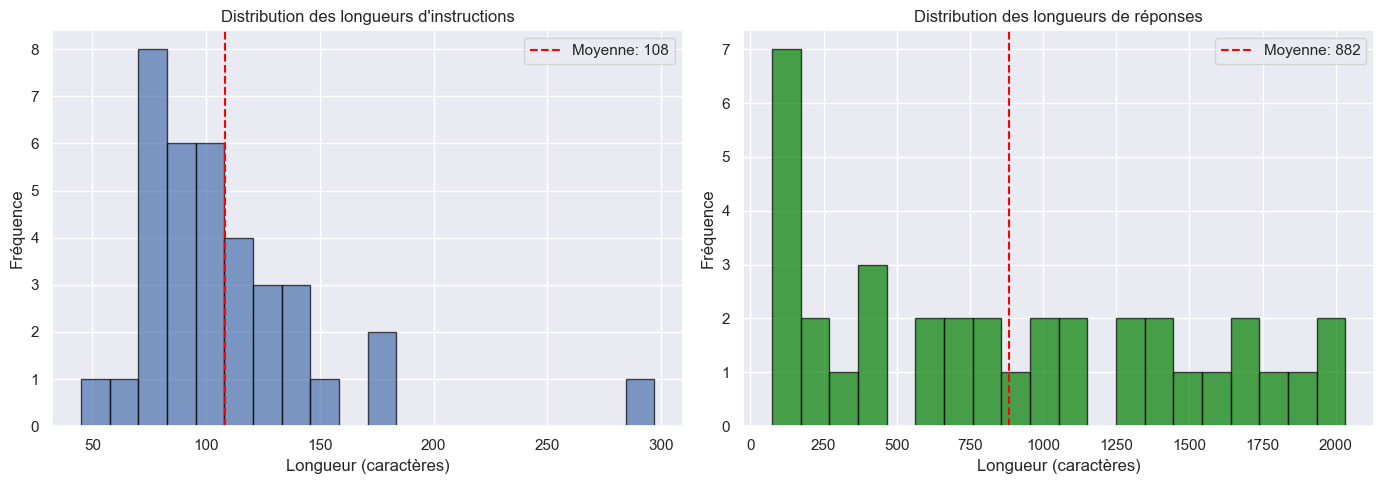

In [33]:
# Visualisations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des longueurs d'instructions
axes[0].hist(df['instruction'].str.len(), bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Longueur (caract√®res)')
axes[0].set_ylabel('Fr√©quence')
axes[0].set_title('Distribution des longueurs d\'instructions')
axes[0].axvline(df['instruction'].str.len().mean(), color='red', 
                linestyle='--', label=f'Moyenne: {df["instruction"].str.len().mean():.0f}')
axes[0].legend()

# Distribution des longueurs de r√©ponses
axes[1].hist(df['response'].str.len(), bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Longueur (caract√®res)')
axes[1].set_ylabel('Fr√©quence')
axes[1].set_title('Distribution des longueurs de r√©ponses')
axes[1].axvline(df['response'].str.len().mean(), color='red', 
                linestyle='--', label=f'Moyenne: {df["response"].str.len().mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Sauvegarde du dataset

Nous sauvegardons le dataset dans plusieurs formats pour faciliter son utilisation ult√©rieure.

In [34]:
import os
from pathlib import Path

# Cr√©ation du dossier de sortie
output_dir = Path("../data/synthetic")
output_dir.mkdir(parents=True, exist_ok=True)

# Format Alpaca (standard pour le fine-tuning)
alpaca_data = [pair.to_alpaca_format() for pair in synthetic_pairs]
alpaca_path = output_dir / "synthetic_dataset_alpaca.json"
with open(alpaca_path, 'w', encoding='utf-8') as f:
    json.dump(alpaca_data, f, ensure_ascii=False, indent=2)
print(f"‚úÖ Dataset au format Alpaca sauvegard√© : {alpaca_path}")

# Format CSV pour l'analyse
csv_path = output_dir / "synthetic_dataset.csv"
df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"‚úÖ Dataset CSV sauvegard√© : {csv_path}")

# Format JSONL (ligne par ligne, efficace pour le streaming)
jsonl_path = output_dir / "synthetic_dataset.jsonl"
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for pair in synthetic_pairs:
        f.write(json.dumps(pair.to_dict(), ensure_ascii=False) + '\n')
print(f"‚úÖ Dataset JSONL sauvegard√© : {jsonl_path}")

‚úÖ Dataset au format Alpaca sauvegard√© : ../data/synthetic/synthetic_dataset_alpaca.json
‚úÖ Dataset CSV sauvegard√© : ../data/synthetic/synthetic_dataset.csv
‚úÖ Dataset JSONL sauvegard√© : ../data/synthetic/synthetic_dataset.jsonl


## 9. Contr√¥le qualit√© et filtrage

Il est important de v√©rifier la qualit√© des donn√©es g√©n√©r√©es avant de les utiliser pour le fine-tuning.

In [35]:
def quality_check(pair: InstructionPair) -> Tuple[bool, List[str]]:
    """
    V√©rifie la qualit√© d'une paire instruction-r√©ponse.
    
    Returns:
        (pass_check, list_of_issues)
    """
    issues = []
    
    # V√©rifications de base
    if len(pair.instruction) < 10:
        issues.append("Instruction trop courte")
    if len(pair.response) < 20:
        issues.append("R√©ponse trop courte")
    if len(pair.instruction) > 500:
        issues.append("Instruction trop longue")
    if len(pair.response) > 1000:
        issues.append("R√©ponse trop longue")
    
    # V√©rification de la pr√©sence de caract√®res sp√©ciaux probl√©matiques
    if any(char in pair.instruction + pair.response for char in ['\x00', '\r']):
        issues.append("Caract√®res sp√©ciaux d√©tect√©s")
    
    # V√©rification de la coh√©rence
    if '?' not in pair.instruction:
        issues.append("L'instruction ne contient pas de question")
    
    return len(issues) == 0, issues

# Application du contr√¥le qualit√©
quality_results = []
for pair in synthetic_pairs:
    passed, issues = quality_check(pair)
    quality_results.append({
        'passed': passed,
        'issues': issues,
        'pair': pair
    })

# Statistiques de qualit√©
passed_count = sum(1 for r in quality_results if r['passed'])
print(f"üìä R√©sultats du contr√¥le qualit√© :")
print(f"   - Paires valid√©es : {passed_count}/{len(quality_results)} ({100*passed_count/len(quality_results):.1f}%)")

# Affichage des probl√®mes les plus fr√©quents
all_issues = [issue for r in quality_results for issue in r['issues']]
if all_issues:
    from collections import Counter
    issue_counts = Counter(all_issues)
    print("\nüîç Probl√®mes d√©tect√©s :")
    for issue, count in issue_counts.most_common(5):
        print(f"   - {issue}: {count} occurrences")

üìä R√©sultats du contr√¥le qualit√© :
   - Paires valid√©es : 21/36 (58.3%)

üîç Probl√®mes d√©tect√©s :
   - R√©ponse trop longue: 15 occurrences


In [36]:
# Sauvegarde du dataset filtr√©
filtered_pairs = [r['pair'] for r in quality_results if r['passed']]

if filtered_pairs:
    filtered_path = output_dir / "synthetic_dataset_filtered.json"
    with open(filtered_path, 'w', encoding='utf-8') as f:
        json.dump(
            [pair.to_alpaca_format() for pair in filtered_pairs],
            f,
            ensure_ascii=False,
            indent=2
        )
    print(f"\n‚úÖ Dataset filtr√© sauvegard√© : {filtered_path}")
    print(f"   Contient {len(filtered_pairs)} paires de haute qualit√©")


‚úÖ Dataset filtr√© sauvegard√© : ../data/synthetic/synthetic_dataset_filtered.json
   Contient 21 paires de haute qualit√©


## 10. Pr√©paration pour le fine-tuning

### Recommandations pour l'√©tape suivante

Votre dataset synth√©tique est maintenant pr√™t pour le fine-tuning ! Voici quelques recommandations :

1. **Taille du dataset** : 
   - Minimum recommand√© : 100-500 paires pour un fine-tuning basique
   - Id√©al : 1000-5000 paires pour de meilleurs r√©sultats

2. **Diversit√©** :
   - Variez les types de questions (factuelle, analytique, cr√©ative)
   - Utilisez diff√©rents domaines de contexte

3. **Qualit√©** :
   - Privil√©giez la qualit√© √† la quantit√©
   - V√©rifiez manuellement un √©chantillon

4. **Format** :
   - Le format Alpaca est directement utilisable avec la plupart des frameworks
   - Gardez une trace du contexte original pour l'√©valuation

In [37]:
# R√©sum√© final
print("üéâ G√©n√©ration de dataset synth√©tique termin√©e !\n")
print("üìä R√©sum√© :")
print(f"   - Documents sources trait√©s : {NUM_DOCS_TO_PROCESS}")
print(f"   - Paires g√©n√©r√©es : {len(synthetic_pairs)}")
print(f"   - Paires de haute qualit√© : {len(filtered_pairs) if filtered_pairs else 0}")
print(f"\nüìÅ Fichiers cr√©√©s :")
print(f"   - {alpaca_path.name} (format Alpaca pour fine-tuning)")
print(f"   - {csv_path.name} (format CSV pour analyse)")
print(f"   - {jsonl_path.name} (format JSONL pour streaming)")
if filtered_pairs:
    print(f"   - {filtered_path.name} (dataset filtr√©)")

print("\nüöÄ Prochaine √©tape : Notebook 02 - Fine-tuning avec LoRA")

üéâ G√©n√©ration de dataset synth√©tique termin√©e !

üìä R√©sum√© :
   - Documents sources trait√©s : 50
   - Paires g√©n√©r√©es : 36
   - Paires de haute qualit√© : 21

üìÅ Fichiers cr√©√©s :
   - synthetic_dataset_alpaca.json (format Alpaca pour fine-tuning)
   - synthetic_dataset.csv (format CSV pour analyse)
   - synthetic_dataset.jsonl (format JSONL pour streaming)
   - synthetic_dataset_filtered.json (dataset filtr√©)

üöÄ Prochaine √©tape : Notebook 02 - Fine-tuning avec LoRA


## üìö Pour aller plus loin

### Am√©liorations possibles

1. **Diversification des prompts** :
   - Cr√©er plusieurs templates de prompts
   - Adapter les prompts selon le type de contenu

2. **Techniques avanc√©es** :
   - Self-instruct : Utiliser le mod√®le pour g√©n√©rer ses propres instructions

3. **Validation** :
   - Utiliser un mod√®le diff√©rent pour valider les r√©ponses
   - Impl√©menter un syst√®me de scoring
   - Cross-validation avec des annotateurs humains


### Exercices propos√©s

1. **Modifier les prompts** pour g√©n√©rer des instructions dans un domaine sp√©cifique (m√©dical, juridique, technique)
2. **Impl√©menter un syst√®me de scoring** pour √©valuer automatiquement la qualit√© des paires
3. **Cr√©er une pipeline de validation** avec le m√™me mod√®le ou un second mod√®le (LLM as a judge)
4. **Exp√©rimenter avec diff√©rentes temp√©ratures** et analyser l'impact sur la diversit√© des contenus